# **Данные**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture
from scipy.stats import norm, multivariate_normal
from scipy.integrate import quad
from scipy.stats import gaussian_kde

In [2]:
data = pd.read_excel('euro_dollar.xlsx')
data = data.sort_values(by = ['curs_euro'])
data.head()

,date,curs_dollar,curs_euro,cum_dollar,cum_euro
3809,2014-12-18,-0.128638,-0.142679,1.232742,1.556321
5605,2022-04-07,-0.079885,-0.084087,1.482782,1.517790
3811,2014-12-20,-0.071521,-0.074047,1.110268,1.406443
5595,2022-03-24,-0.071473,-0.071291,2.151096,2.210241
5638,2022-05-28,-0.051060,-0.070371,1.020191,0.915850


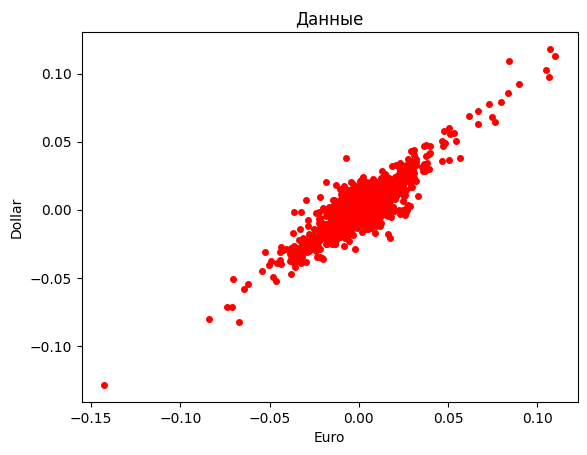

In [3]:
list_of_euro = list(data['curs_euro'])
list_of_dollar = list(data['curs_dollar'])
n_samples = data['curs_euro'].size
n_samples
plt.title('Данные')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(data['curs_euro'], data['curs_dollar'], 'ro', markersize=4)
#plt.legend(['С шумом', 'Истинный'])
plt.show()

In [4]:
np_data_dollar = np.array(data['curs_dollar']).reshape(-1, 1)
np_data_euro = np.array(data['curs_euro']).reshape(-1, 1)
np_data_euro

array([[-0.14267898],
       [-0.08408749],
       [-0.07404701],
       ...,
       [ 0.10664213],
       [ 0.10718334],
       [ 0.10994489]])

In [5]:
data_XY = np.concatenate([np_data_euro, np_data_dollar], axis = 1)
data_XY

array([[-0.14267898, -0.12863818],
       [-0.08408749, -0.07988462],
       [-0.07404701, -0.07152092],
       ...,
       [ 0.10664213,  0.09724502],
       [ 0.10718334,  0.11812002],
       [ 0.10994489,  0.11316388]])

# **Расчёт метода в двумерном случае**

## **Разделяем на смесь**

### **Выбор модели по BIC**

In [6]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 20),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(data_XY)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 20)},
             scoring=<function gmm_bic_score at 0x000001CAA4583740>)

In [7]:
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
58,2,full,-16384.212905
19,1,tied,-15785.578638
57,1,full,-15785.578638
59,3,full,-15564.400751
1,2,spherical,-15411.440200


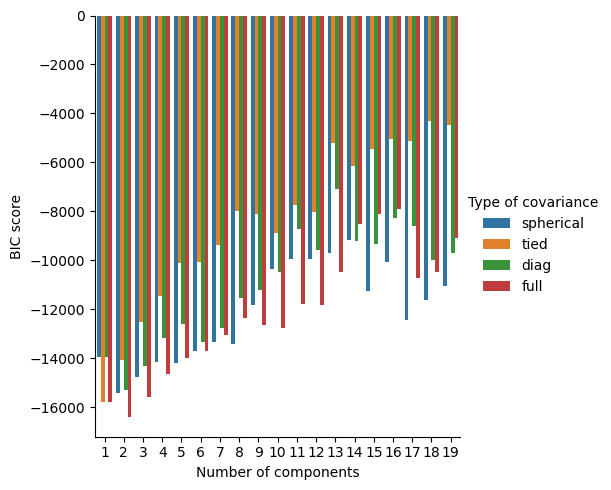

In [8]:
sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

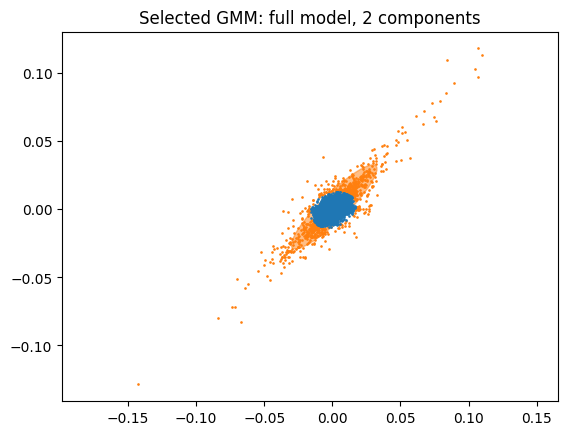

In [9]:
from matplotlib.patches import Ellipse
from scipy import linalg

color_iter = sns.color_palette("tab10", 2)[::-1]
Y_ = grid_search.predict(data_XY)

fig, ax = plt.subplots()

for i, (mean, cov, color) in enumerate(
    zip(
        grid_search.best_estimator_.means_,
        grid_search.best_estimator_.covariances_,
        color_iter,
    )
):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(data_XY[Y_ == i, 0], data_XY[Y_ == i, 1], 0.8, color=color)

    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
    ellipse.set_clip_box(fig.bbox)
    ellipse.set_alpha(0.5)
    ax.add_artist(ellipse)

plt.title(
    f"Selected GMM: {grid_search.best_params_['covariance_type']} model, "
    f"{grid_search.best_params_['n_components']} components"
)
plt.axis("equal")
plt.show()

In [22]:
best_2_dim_gmm = grid_search.best_estimator_
best_2_dim_gmm.weights_

array([0.14963746, 0.85036254])

### **Строим регрессию на примере**

In [23]:
best_2_dim_gmm = mixture.GaussianMixture(n_components=12)
best_2_dim_gmm.fit(data_XY)
best_2_dim_gmm.covariances_.shape

(12, 2, 2)

In [11]:
def cur_pdf_2_dim_dot_y (y, a):
    p_a_y = 0
    for i in range(best_2_dim_gmm.means_.shape[0]):
        p_a_y += multivariate_normal.pdf([a, y], best_2_dim_gmm.means_[i], best_2_dim_gmm.covariances_[i]) * best_2_dim_gmm.weights_[i]

    return p_a_y * y

def cur_pdf_2_dim (y, a):
    p_a_y = 0
    for i in range(best_2_dim_gmm.means_.shape[0]):
        p_a_y += multivariate_normal.pdf([a, y], best_2_dim_gmm.means_[i], best_2_dim_gmm.covariances_[i]) * best_2_dim_gmm.weights_[i]

    return p_a_y

In [23]:
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 + 10)
a_s = [i / 1000 for i in range(-100, maximum)]
res = []
for a in a_s:
    # if p_a != 0:
    print(a)
    res.append(quad(cur_pdf_2_dim_dot_y, -np.inf, np.inf, args=(a))[0]/ quad(cur_pdf_2_dim, -np.inf, np.inf, args=(a))[0])
    # else:
    #     res.append(0)

-0.1
-0.099
-0.098
-0.097
-0.096
-0.095
-0.094
-0.093
-0.092
-0.091
-0.09
-0.089
-0.088
-0.087
-0.086
-0.085
-0.084
-0.083
-0.082
-0.081
-0.08
-0.079
-0.078
-0.077
-0.076
-0.075
-0.074
-0.073
-0.072
-0.071
-0.07
-0.069
-0.068
-0.067
-0.066
-0.065
-0.064
-0.063
-0.062
-0.061
-0.06
-0.059
-0.058
-0.057
-0.056
-0.055
-0.054
-0.053
-0.052
-0.051
-0.05
-0.049
-0.048
-0.047
-0.046
-0.045
-0.044
-0.043
-0.042
-0.041
-0.04
-0.039
-0.038
-0.037
-0.036
-0.035
-0.034
-0.033
-0.032
-0.031
-0.03
-0.029
-0.028
-0.027
-0.026
-0.025
-0.024
-0.023
-0.022
-0.021
-0.02
-0.019
-0.018
-0.017
-0.016
-0.015
-0.014
-0.013
-0.012
-0.011
-0.01
-0.009
-0.008
-0.007
-0.006
-0.005
-0.004
-0.003
-0.002
-0.001
0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009
0.01
0.011
0.012
0.013
0.014
0.015
0.016
0.017
0.018
0.019
0.02
0.021
0.022
0.023
0.024
0.025
0.026
0.027
0.028
0.029
0.03
0.031
0.032
0.033
0.034
0.035
0.036
0.037
0.038
0.039
0.04
0.041
0.042
0.043
0.044
0.045
0.046
0.047
0.048
0.049
0.05
0.051
0.052


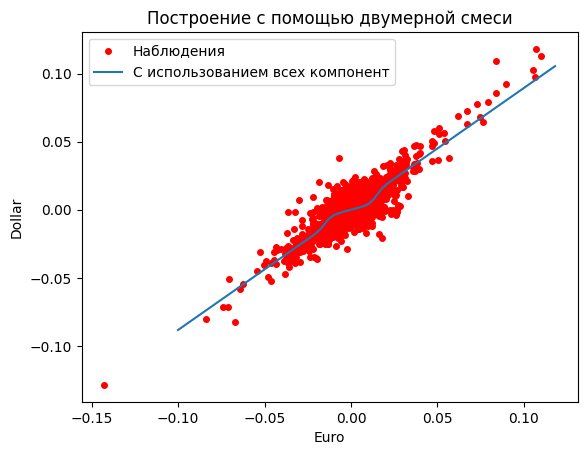

In [24]:
plt.title('Построение с помощью двумерной смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(a_s, res)
plt.legend(['Наблюдения', 'С использованием всех компонент'])
plt.show()

### **Расчёт с помощью прямой формулы**

In [75]:
def p_a(a, gmm, cov_type):
    if cov_type == 'full':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[:, 0, 0] ** 0.5) * gmm.weights_
    if cov_type == 'diag':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[:, 0] ** 0.5) * gmm.weights_
    if cov_type == 'spherical':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_ ** 0.5) * gmm.weights_
    if cov_type == 'tied':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[0, 0] ** 0.5) * gmm.weights_
    

# def p_a_i(a, gmm, i):
#     return norm.pdf(a, gmm.means_[i, 0], gmm.covariances_[i, 0, 0] ** 0.5)

def E_y_a (a, gmm, cov_type):
    if cov_type == 'full':
        return gmm.means_[:, 1] + gmm.covariances_[:, 0, 1] * (a - gmm.means_[:, 0]) / gmm.covariances_[:, 0, 0]
    if cov_type == 'diag':
        return gmm.means_[:, 1]
    if cov_type == 'spherical':
        return gmm.means_[:, 1]
    if cov_type == 'tied':
        return gmm.means_[:, 1] + gmm.covariances_[0, 1] * (a - gmm.means_[:, 0]) / gmm.covariances_[0, 0]

In [71]:
gmm = mixture.GaussianMixture(n_components=2, covariance_type='tied')
gmm.fit(data_XY)
gmm.covariances_

array([[9.16776293e-05, 6.93223009e-05],
       [6.93223009e-05, 8.48660365e-05]])

In [60]:
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 + 10)
a_s = [i / 1000 for i in range(minimum, maximum)]
res = []
p_a_s = p_a(np.array(a_s).reshape(-1, 1), gmm)
res = (E_y_a(np.array(a_s).reshape(-1, 1), gmm) * p_a_s).sum(axis= 1) / p_a_s.sum(axis = 1)

In [61]:
# p_a_s = p_a(np_data_euro, best_2_dim_gmm)
# res = (E_y_a(np_data_euro, best_2_dim_gmm) * p_a_s).sum(axis= 1) / p_a_s.sum(axis = 1)

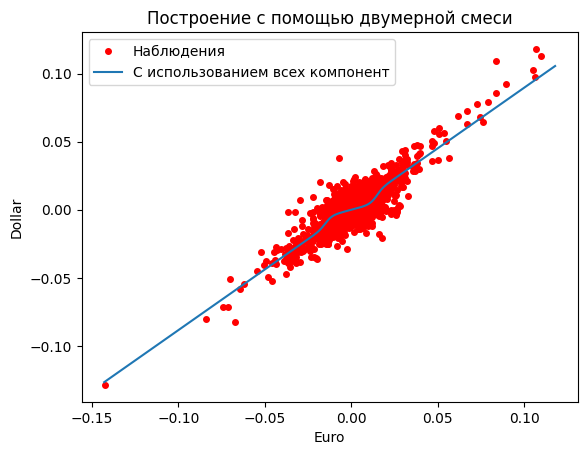

In [62]:
plt.title('Построение с помощью двумерной смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(a_s, res)
plt.legend(['Наблюдения', 'С использованием всех компонент'])
plt.show()

## **Подбираем лучшую модель по BIC**

In [77]:
def p_a(a, gmm, cov_type):
    if cov_type == 'full':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[:, 0, 0] ** 0.5) * gmm.weights_
    if cov_type == 'diag':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[:, 0] ** 0.5) * gmm.weights_
    if cov_type == 'spherical':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_ ** 0.5) * gmm.weights_
    if cov_type == 'tied':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[0, 0] ** 0.5) * gmm.weights_
    

# def p_a_i(a, gmm, i):
#     return norm.pdf(a, gmm.means_[i, 0], gmm.covariances_[i, 0, 0] ** 0.5)

def E_y_a (a, gmm, cov_type):
    if cov_type == 'full':
        return gmm.means_[:, 1] + gmm.covariances_[:, 0, 1] * (a - gmm.means_[:, 0]) / gmm.covariances_[:, 0, 0]
    if cov_type == 'diag':
        return gmm.means_[:, 1]
    if cov_type == 'spherical':
        return gmm.means_[:, 1]
    if cov_type == 'tied':
        return gmm.means_[:, 1] + gmm.covariances_[0, 1] * (a - gmm.means_[:, 0]) / gmm.covariances_[0, 0]

In [79]:
var_Y = np_data_dollar.var(ddof= 1)
max_R_2 = 0
min_cov = 1

min_bic = np.inf
best_bic_R_2 = 0
best_bic_cov = 1

bics = []
R_s = []
covs = []

cv_types = ['spherical', 'tied', 'diag', 'full']
# cv_types = ['full']
n_components_range = range(1, 50)
for n_components in n_components_range:
    print(f"Сейчас обучается модель с {n_components} компонентами")
    cur_R_s = []
    cur_covs = []
    cur_bics = []
    for cv_type in cv_types:
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(data_XY)

        p_a_s = p_a(np_data_euro, gmm, cv_type)
        res = (E_y_a(np_data_euro, gmm, cv_type) * p_a_s).sum(axis= 1) / p_a_s.sum(axis = 1)

        E_Y_X = res.reshape(-1, 1)
        residiuals = np_data_dollar - E_Y_X
        covar = np.cov(E_Y_X.flatten(), residiuals.flatten())[0][1]

        var_E_X_Y = E_Y_X.var(ddof= 1)
        var_resid = sum((residiuals ** 2) / (n_samples - 1))

        density = gaussian_kde(residiuals.T[0])
        LogLikelihood = np.log(density(residiuals.T[0])).sum()

        R_2 = var_E_X_Y / var_Y
        cov_part = 2 * covar / var_Y
        bic = -2 * LogLikelihood + (2 * n_components + n_components - 1) * np.log(n_samples)

        cur_bics.append(bic)
        cur_R_s.append(R_2)
        cur_covs.append(cov_part)

        if cov_part <= 0.05 and R_2 > max_R_2:
            max_R_2 = R_2
            min_cov = cov_part
            best_gmm = gmm

        if bic < min_bic:
            min_bic = bic
            best_gmm_bic = gmm
            best_bic_R_2 = R_2
            best_bic_cov = cov_part
    
    bics.append(cur_bics)
    R_s.append(cur_R_s)
    covs.append(cur_covs)

Сейчас обучается модель с 1 компонентами
Сейчас обучается модель с 2 компонентами
Сейчас обучается модель с 3 компонентами
Сейчас обучается модель с 4 компонентами
Сейчас обучается модель с 5 компонентами
Сейчас обучается модель с 6 компонентами
Сейчас обучается модель с 7 компонентами
Сейчас обучается модель с 8 компонентами
Сейчас обучается модель с 9 компонентами
Сейчас обучается модель с 10 компонентами
Сейчас обучается модель с 11 компонентами
Сейчас обучается модель с 12 компонентами
Сейчас обучается модель с 13 компонентами
Сейчас обучается модель с 14 компонентами
Сейчас обучается модель с 15 компонентами
Сейчас обучается модель с 16 компонентами
Сейчас обучается модель с 17 компонентами
Сейчас обучается модель с 18 компонентами
Сейчас обучается модель с 19 компонентами
Сейчас обучается модель с 20 компонентами
Сейчас обучается модель с 21 компонентами
Сейчас обучается модель с 22 компонентами
Сейчас обучается модель с 23 компонентами
Сейчас обучается модель с 24 компонентами
С

In [80]:
R_S = np.array(R_s)
COVS = np.array(covs)
BICS = np.array(bics)

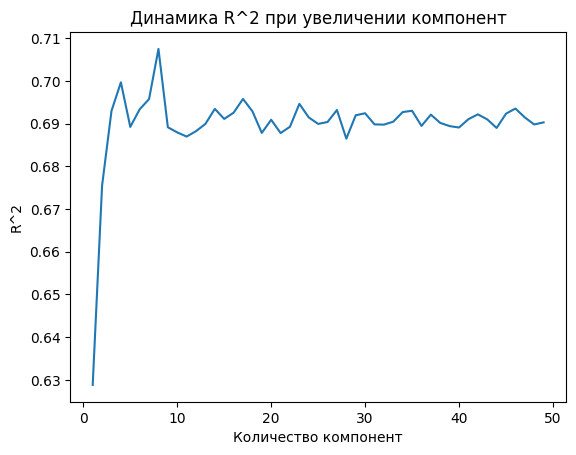

In [49]:
plt.title('Динамика R^2 при увеличении компонент')
plt.xlabel('Количество компонент')
plt.ylabel('R^2')
plt.plot(n_components_range, R_S[:, 0])
plt.show()

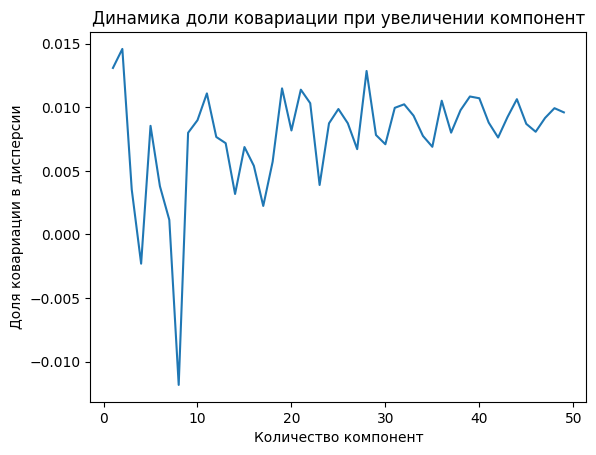

In [50]:
plt.title('Динамика доли ковариации при увеличении компонент')
plt.xlabel('Количество компонент')
plt.ylabel('Доля ковариации в дисперсии')
plt.plot(n_components_range, COVS[:, 0])
plt.show()

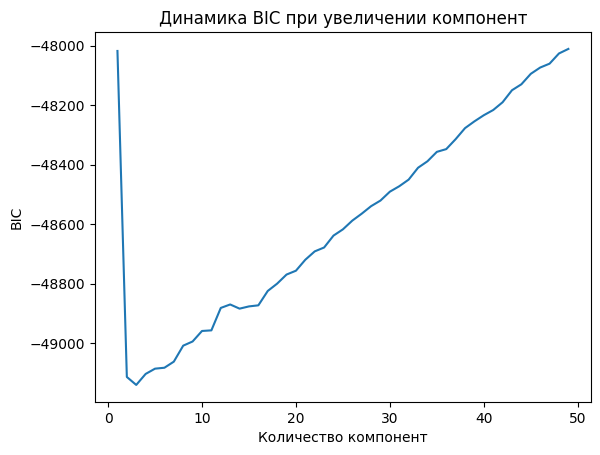

In [86]:
plt.title('Динамика BIC при увеличении компонент')
plt.xlabel('Количество компонент')
plt.ylabel('BIC')
plt.plot(n_components_range, BICS[:, 3])
plt.show()

In [81]:
print(f"Лучший R^2: {max_R_2}")
print(f"Соответствующая доля ковариации: {min_cov}")
best_gmm

Лучший R^2: 0.7158077038562207
Соответствующая доля ковариации: -0.028053831731723388


GaussianMixture(covariance_type='tied', n_components=11)

In [82]:
print(f"Лучший BIC: {min_bic}")
print(f"Соответствующий R^2: {best_bic_R_2}")
print(f"Соответствующая доля ковариации: {best_bic_cov}")
best_gmm_bic

Лучший BIC: -49140.54598726804
Соответствующий R^2: 0.6929119586670591
Соответствующая доля ковариации: -0.005104249700969717


GaussianMixture(n_components=3)

In [56]:
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 + 10)
a_s = [i / 1000 for i in range(minimum, maximum)]
res = []
p_a_s = p_a(np.array(a_s).reshape(-1, 1), best_gmm_bic)
res = (E_y_a(np.array(a_s).reshape(-1, 1), best_gmm_bic) * p_a_s).sum(axis= 1) / p_a_s.sum(axis = 1)

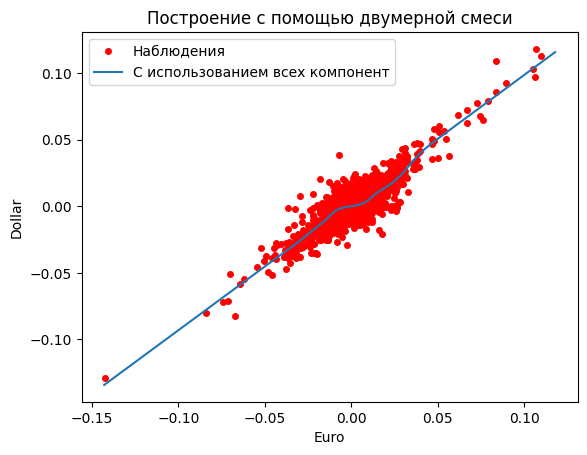

In [57]:
plt.title('Построение с помощью двумерной смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(a_s, res)
plt.legend(['Наблюдения', 'С использованием всех компонент'])
plt.show()